# NASA Space Apps Challenge

In [1]:
%pip install numpy
%pip install pandas
%pip install obspy 
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import Libraries

import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

# Read the Catalog Data

In [16]:
cat_file = r'C:\Users\yman7\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

# Extract the file name from the path
file_name = os.path.basename(cat_file)

# Display the extracted file name
print(file_name)

apollo12_catalog_GradeA_final.csv


# Select a Detection

In [4]:
#dont need as it is absolute, I will be using relative
row = cat.iloc[15]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1971, 1, 15, 12, 40)

In [5]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

np.int64(45600)

In [6]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1971-01-15HR00_evid00022'

# Read the CSV file 

In [7]:
data_directory = r'C:\Users\yman7\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\data\S12_GradeA\\'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat



,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1971-01-15T00:00:00.258000,0.000000,-1.813238e-15
1,1971-01-15T00:00:00.408943,0.150943,-6.975340e-16
2,1971-01-15T00:00:00.559887,0.301887,2.335177e-16
3,1971-01-15T00:00:00.710830,0.452830,1.821918e-16
4,1971-01-15T00:00:00.861774,0.603774,-6.603485e-16
...,...,...,...
572406,1971-01-16T00:00:01.163660,86400.905660,-4.188665e-17
572407,1971-01-16T00:00:01.314604,86401.056604,-3.584254e-17
572408,1971-01-16T00:00:01.465547,86401.207547,-3.442232e-17
572409,1971-01-16T00:00:01.616491,86401.358491,-3.040052e-17


# Use relative time to read the data

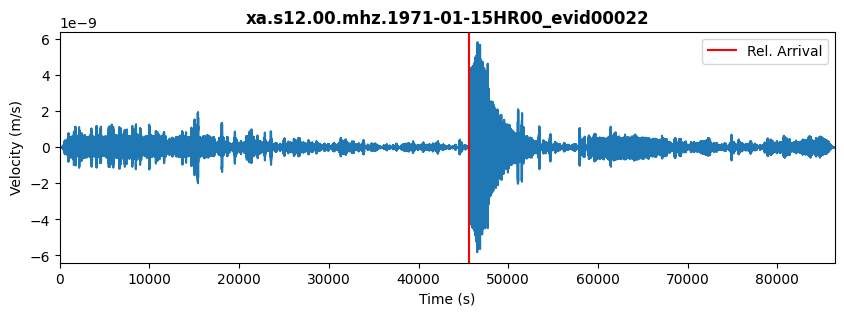

In [8]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3)) 
ax.plot(csv_times,csv_data) #


# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# Filter the Trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz. 

In [9]:
# Assuming 'st' is the stream read from a file, define it first
st = read(os.path.join(data_directory, test_filename + '.mseed'))

# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

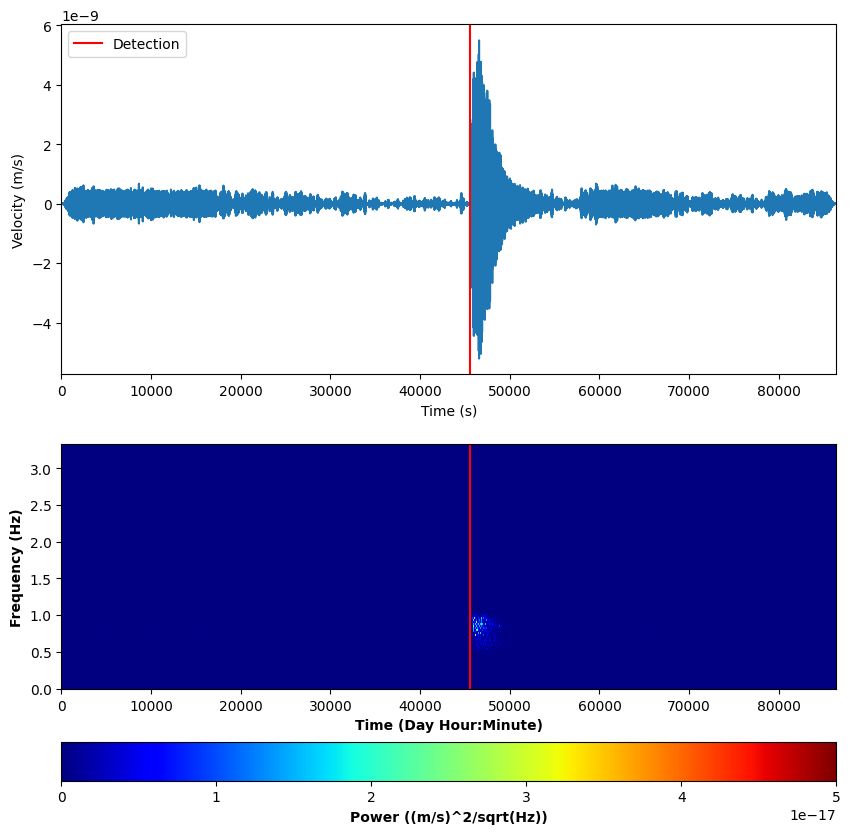

In [10]:
from matplotlib import cm
from scipy.signal import spectrogram

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival_time_rel, color='red',label='Detection')

# Compute the spectrogram
f, t, sxx = spectrogram(tr_data_filt, fs=1/(tr_times_filt[1] - tr_times_filt[0]))
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time_rel, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Sampel Short-Term Average/Long-Term Average (STA/LTA) detection algorithm

Text(0, 0.5, 'Characteristic function')

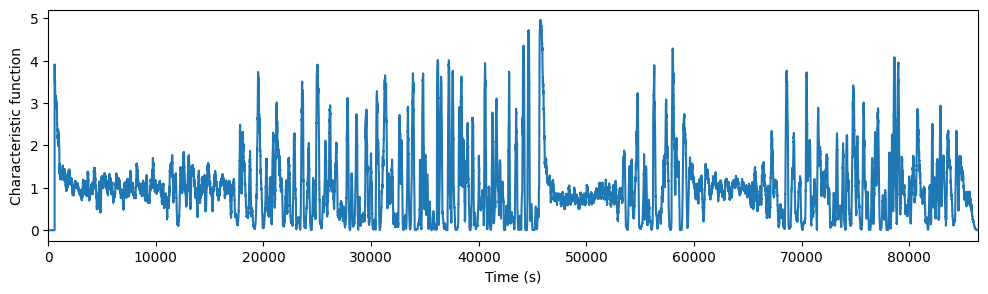

In [11]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
tr = tr_filt
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times_filt, cft)
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

# optimize the threshold data to get the siesmic event NASA VERSION

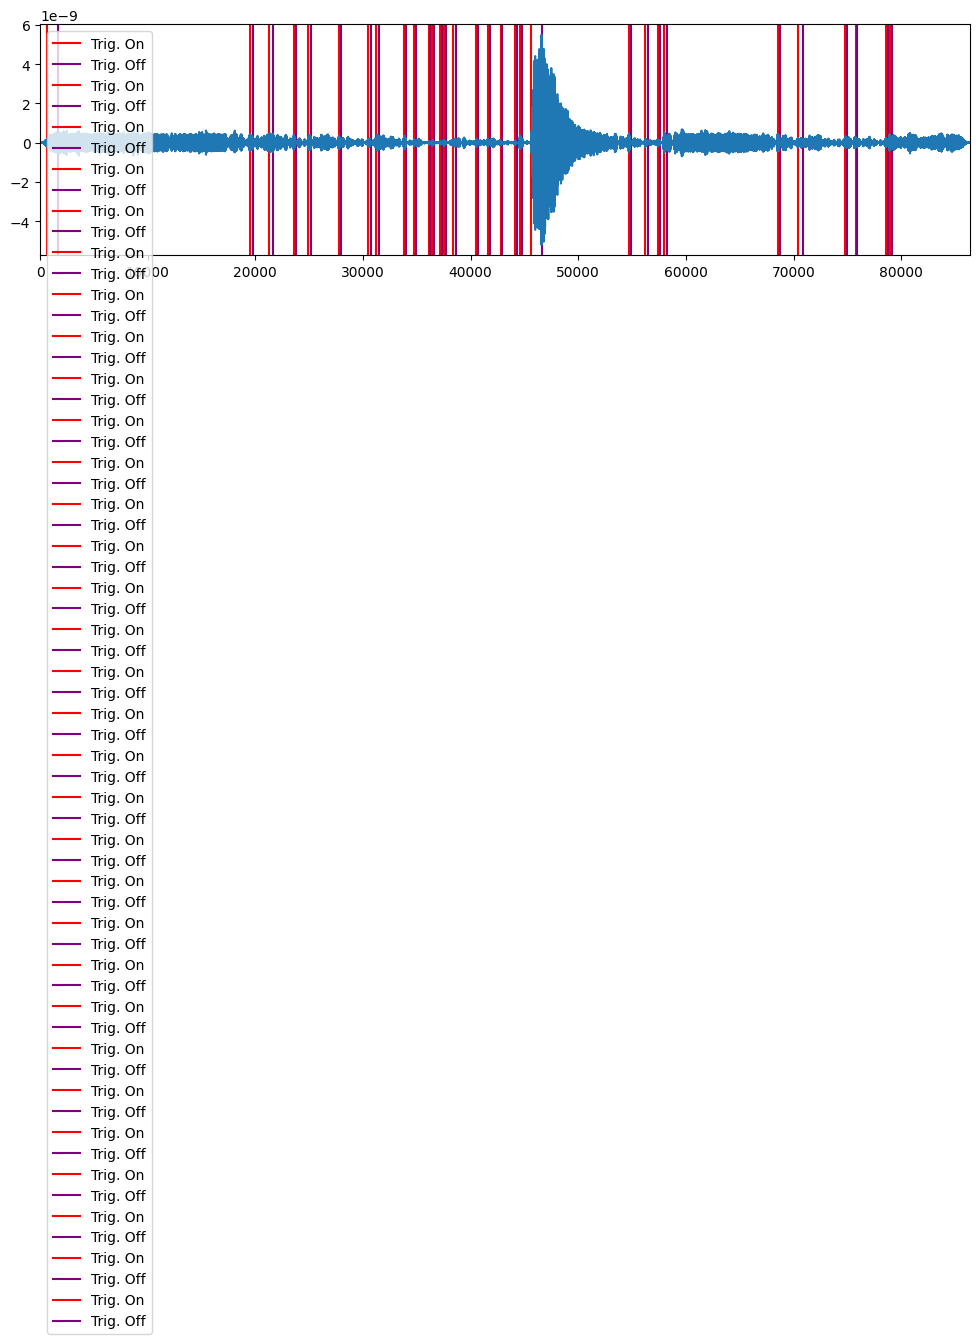

In [12]:
#FROM THE NASA EXAMPLE CODE
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 3
thr_off = 1
on_off = np.array(trigger_onset(cft, thr_on, thr_off))


# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times_filt[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times_filt[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times_filt,tr_data_filt)
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.legend()

# MY VERSION

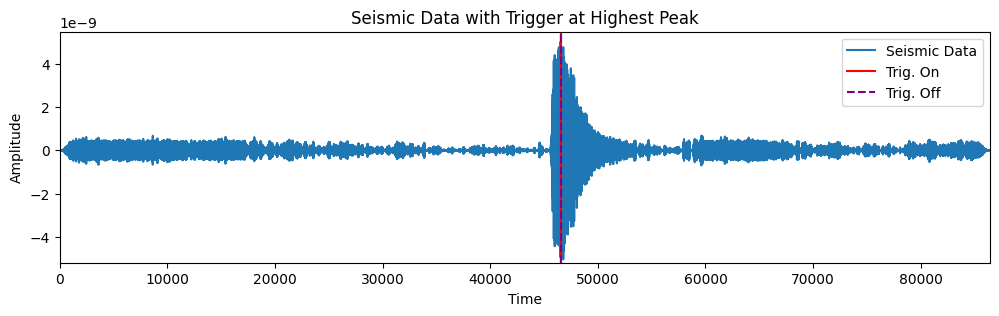

np.float64(46575.84905660377)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming tr_times_filt and tr_data_filt are already defined
# For example:
# tr_times_filt = np.linspace(0, 100, num=1000)  # Replace with actual time data
# tr_data_filt = np.random.randn(1000)  # Replace with actual seismic data

# Find the index of the maximum value in the seismic data
peak_idx = np.argmax(tr_data_filt)

# Plot the seismogram
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# Plot the seismogram
ax.plot(tr_times_filt, tr_data_filt, label='Seismic Data')
ax.axvline(x=tr_times_filt[peak_idx], color='red', label='Trig. On')  # Trigger at peak
ax.axvline(x=tr_times_filt[peak_idx], color='purple', linestyle='dashed', label='Trig. Off')  # Off trigger same as on

# Set plot limits and legends
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_ylim([min(tr_data_filt), max(tr_data_filt)])  # Set limits based on data
ax.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Seismic Data with Trigger at Highest Peak')
plt.show()


#the time of the peak
peak_time = tr_times_filt[peak_idx]
peak_time



# Export into a file

In [17]:
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times_filt[triggers[0]])  # Fix applied here
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)
    
# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times_filt[triggers[0]]})
detect_df.head()


detect_df.to_csv(file_name, index=False)
detect_df



,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T00:10:00.107057,78920.754717
1,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T05:24:29.390075,78920.754717
2,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T05:53:47.880642,78920.754717
3,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T06:32:48.408943,78920.754717
4,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T06:55:35.503283,78920.754717
5,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T07:43:20.710830,78920.754717
6,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T08:28:29.088189,78920.754717
7,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T08:40:14.144792,78920.754717
8,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T09:23:48.031585,78920.754717
9,xa.s12.00.mhz.1971-01-15HR00_evid00022,1971-01-15T09:39:30.069321,78920.754717
